# Set Variables

In [1]:
label1_th = 0.5

# -------- outp_version
output_version = 1092


# -------- method: first
# which_method = "first"
# which_method = "second"
which_method = "third"

if (which_method == "first" or which_method == "third"):
    class_percentage = 0.5 # predictable classes (a)

if (which_method == "second" or which_method == "third"):
    top_k = 20


# -------- method_way
method_way = "c" # a, b, c

if (method_way == "a" and (not which_method == "first")):
    bug_localization_accuracy = [1] # main data - th
    knn_accuracy_threshold =    [1]

if method_way == "b":
    bug_localization_accuracy = [1] # main data - th
    knn_accuracy_threshold = [
        0.5, 0.55, 
        0.6, 0.65, 
        0.7, 0.75, 
        0.8, 0.85, 
        0.9, 0.95
    ]

if method_way == "c":
    bug_localization_accuracy = [0.4, 0.5, 0.6, 0.7, 0.8]
    knn_accuracy_threshold = [
        0.5, 0.55, 
        0.6, 0.65, 
        0.7, 0.75, 
        0.8, 0.85, 
        0.9, 0.95
    ]


# -------- dataset
# software_name = "camel"
# software_name = "cloudstack"
software_name = "geode"
# software_name = "HBase"


# -------- google colab
# on_google_colab = True
on_google_colab = False

In [2]:
print("bla: ", bug_localization_accuracy)
print("th:  ", knn_accuracy_threshold)

bla:  [0.4, 0.5, 0.6, 0.7, 0.8]
th:   [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


# Google Colab

In [3]:
if software_name == "camel":
    dataset_file_name = "dataset_camel - v.01"
    dataset_file_name_ts = "timeserAll_camel - v.01"
    number_of_chunks = 3
    
elif software_name == "cloudstack":
    dataset_file_name = "cloudstack_bugs - v.01"
    dataset_file_name_ts = "cloudstack_TimeSeries - v.01"
    number_of_chunks = 8
    
elif software_name == "geode":
    dataset_file_name = "geode_Bug - v.01"
    dataset_file_name_ts = "geode_TS - v.01"
    number_of_chunks = 4
    
else:
    dataset_file_name = "dataset_hbase - v.03"
    dataset_file_name_ts = "timeserAll - v.03"
    number_of_chunks = 4

In [4]:
if on_google_colab:
    
    !pip install enlighten
    !pip install --upgrade statsmodels 
    !pip install --upgrade matplotlib
    
    # load data from google drive
    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=True)
    !ls "/content/gdrive/My Drive/"
    
    tempPre = "gdrive/MyDrive/Colab Notebooks/paper/Indirect Method/"
    pre_path_data = tempPre + "data/" + software_name + "/"
    
    # you can choose one of these and comment out the other:
    # pre_path_output = tempPre + "output/"
    pre_path_output = tempPre + "output/" + dataset_file_name + "/" + which_method + "/"

else:
    tempPre =    "E:/darsy/00/02- arshad/10- paper code/"
    tempData =   "00- My Data/Datasets/Indirect Method/"
    tempOutput = "01- Jupyter Notebook/InDirect Method/00. Output/"
    pre_path_data =   tempPre + tempData   + software_name + "/"
    pre_path_output = tempPre + tempOutput + software_name + "/" + dataset_file_name + "/" + which_method + "/"

# Libs

In [5]:
import random 
import json
import math
import os

import enlighten
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import truediv
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from sklearn.neighbors import KNeighborsClassifier

In [6]:
import warnings
warnings.filterwarnings("ignore")

# Config

In [7]:
mypaths = {
    "dataset": pre_path_data + dataset_file_name    + ".csv", 
    "timeser": pre_path_data + dataset_file_name_ts + ".csv", 
    "output_performance": pre_path_output + "performance-v{}.json".format(output_version)
}

preprocessing_params = {
    "dataset": {
        # time_stamp is the time that we change the class for a bug fixing.
        # id stands for identifier
        "columns_name":   ["bug_report_id", "class_id", "time_stamp", "label"],
        "columns_dtype" : {0: "int64", 1: "int64", 2: "int64", 3:"int32"}
    },
    
    "timeser": {
        "columns_name":   ["class_id", "time_stamp", "label"],
        "columns_dtype" : {0: "int64", 1: "int64", 2:"int32"}
    },
    
    # 0: no change | 1: increase bad smell | -1: decrease bad smell
    "class_labels": [0, 1, -1], 
    "num_classes": 3,
    "bc2_labels": [0, 1],
    "bc2_num_classes": 2,
    "top_k": None,
    "class_percentage": None,
    "label1_th": label1_th,
}

if (which_method == "first" or which_method == "third"):
    preprocessing_params["class_percentage"] = class_percentage

if (which_method == "second" or which_method == "third"):
    preprocessing_params["top_k"] = top_k
    
    

knn_model_params = {
    "train_size": 0.8,
    "n_neighbors": 5
}

progress_colours = ["webmaroon", "salmon", "orangered", "deeppink3", "crimson", 
                    "black", "blue", "gray", "cyan4", "darkgreen"]

# Read Files

## df_main

In [8]:
df_main = pd.read_csv(
    mypaths["dataset"], 
    names=preprocessing_params["dataset"]["columns_name"], 
    dtype=preprocessing_params["dataset"]["columns_dtype"], 
    header=None
)

## df_data_pred_empty

In [9]:
pred_col_name = []
pred_col_name.extend(preprocessing_params["dataset"]["columns_name"])
pred_col_type = {}
pred_col_type.update(preprocessing_params["dataset"]["columns_dtype"])
count = len(pred_col_type)
for th in knn_accuracy_threshold:
    temp1 = "predictions_" + str(th)
    pred_col_name.append(temp1)
    pred_col_type[count] = pd.Int32Dtype()
    count += 1

In [10]:
pred_col_type

{0: 'int64',
 1: 'int64',
 2: 'int64',
 3: 'int32',
 4: Int32Dtype(),
 5: Int32Dtype(),
 6: Int32Dtype(),
 7: Int32Dtype(),
 8: Int32Dtype(),
 9: Int32Dtype(),
 10: Int32Dtype(),
 11: Int32Dtype(),
 12: Int32Dtype(),
 13: Int32Dtype()}

In [11]:
print(len(pred_col_name))
pred_col_name

14


['bug_report_id',
 'class_id',
 'time_stamp',
 'label',
 'predictions_0.5',
 'predictions_0.55',
 'predictions_0.6',
 'predictions_0.65',
 'predictions_0.7',
 'predictions_0.75',
 'predictions_0.8',
 'predictions_0.85',
 'predictions_0.9',
 'predictions_0.95']

In [12]:
temp = {}
for cn, cd in zip(pred_col_name, pred_col_type.values()):
        temp[cn] = pd.Series(dtype=cd)
df_data_pred_empty = pd.DataFrame(temp)

df_data_pred_empty

,bug_report_id,class_id,time_stamp,label,predictions_0.5,predictions_0.55,predictions_0.6,predictions_0.65,predictions_0.7,predictions_0.75,predictions_0.8,predictions_0.85,predictions_0.9,predictions_0.95


## df_data_pred

In [13]:
df_data_pred = {}

for bla in bug_localization_accuracy:
    print("*" * 10, bla)
    df_data_pred[bla] = df_data_pred_empty.copy()
    for which_chunck in range(number_of_chunks):
        if which_method == "first":
            print("first")
            path_folder = pre_path_data + "first/bla={}/pred/".format(bla)
            sub_chunck_file_pred = "{} _ bla={} - {}-pred.csv".format(dataset_file_name, 
                                                                      bla, which_chunck)

        else:
            path_folder = pre_path_data + "second/k={}/bla={}/pred/".format(top_k, bla)
            sub_chunck_file_pred = "{} _ k={}, bla={} - {}-pred.csv".format(dataset_file_name, top_k, 
                                                                            bla, which_chunck)


        sub_full_path = path_folder + sub_chunck_file_pred
        print(sub_full_path)
        print(os.path.isfile(sub_full_path))
        temp2 = pd.read_csv(
            sub_full_path, 
            dtype=pred_col_type
        )
        df_data_pred[bla] = df_data_pred[bla].append(temp2, ignore_index=True)

********** 0.4
E:/darsy/00/02- arshad/10- paper code/00- My Data/Datasets/Indirect Method/geode/second/k=20/bla=0.4/pred/geode_Bug - v.01 _ k=20, bla=0.4 - 0-pred.csv
True
E:/darsy/00/02- arshad/10- paper code/00- My Data/Datasets/Indirect Method/geode/second/k=20/bla=0.4/pred/geode_Bug - v.01 _ k=20, bla=0.4 - 1-pred.csv
True
E:/darsy/00/02- arshad/10- paper code/00- My Data/Datasets/Indirect Method/geode/second/k=20/bla=0.4/pred/geode_Bug - v.01 _ k=20, bla=0.4 - 2-pred.csv
True
E:/darsy/00/02- arshad/10- paper code/00- My Data/Datasets/Indirect Method/geode/second/k=20/bla=0.4/pred/geode_Bug - v.01 _ k=20, bla=0.4 - 3-pred.csv
True
********** 0.5
E:/darsy/00/02- arshad/10- paper code/00- My Data/Datasets/Indirect Method/geode/second/k=20/bla=0.5/pred/geode_Bug - v.01 _ k=20, bla=0.5 - 0-pred.csv
True
E:/darsy/00/02- arshad/10- paper code/00- My Data/Datasets/Indirect Method/geode/second/k=20/bla=0.5/pred/geode_Bug - v.01 _ k=20, bla=0.5 - 1-pred.csv
True
E:/darsy/00/02- arshad/10- p

In [14]:
df_data_pred

{0.4:        bug_report_id  class_id  time_stamp  label  predictions_0.5  \
 0              27758     90276  1582785511      0             <NA>   
 1              27758    107081  1582785511      0             <NA>   
 2              27758    114937  1582785511      0                0   
 3              27758    103283  1582785511      1             <NA>   
 4              27758     82681  1582785511      0             <NA>   
 ...              ...       ...         ...    ...              ...   
 28044          39606    114374  1435703450      0             <NA>   
 28045          39606    113678  1435703450      0             <NA>   
 28046          39606    115781  1435703450      0             <NA>   
 28047          39606    113169  1435703450      0             <NA>   
 28048          39606    118193  1435703450      0             <NA>   
 
        predictions_0.55  predictions_0.6  predictions_0.65  predictions_0.7  \
 0                  <NA>             <NA>              <NA>  

In [15]:
dfg_brIDs = df_main.groupby("bug_report_id") # brIDs: bug report ids
brIDs_num = len(dfg_brIDs) # number of bug reports
brIDs_num

3610

# DataAfterTimeSerPrediction

In [16]:
class DataAfterTimeSerPrediction:
    def __init__(self, df_data_pred, class_percentage, bug_localization_accuracy, threshold):
        self.class_percentage = class_percentage
        self.df_data_pred_ = df_data_pred
        self.df_data_pred_filtered = {}
        
        self.bla = bug_localization_accuracy
        self.threshold = threshold
    
    
    # ************************** progress lines ************************** #
    
    def progress_lines(self, colours):
        desc = self.set_strings_to_equal_len_()
        total = len(self.threshold)
        manager = enlighten.get_manager()
        progresses = {}
        for i, bla in enumerate(self.bla):
            prog = manager.counter(total=total, desc=desc[i], unit="sample", color=colours[i])
            prog.refresh()
            progresses[bla] = prog
        self.progresses = progresses
    
    
    def set_strings_to_equal_len_(self):
        words = []
        for bla in self.bla:
            desc = "filter-bla-" + str(bla)
            words.append(desc)
        
        max_len = 0
        longest_string_length = len(max(words, key=len))
        w = []
        for i, word in enumerate(words):
            temp = longest_string_length - len(word)
            w.append(word + " " * temp)
        return w
    
    
    # ************************** filter_data ************************** #
    
    def filter_data(self, which_method):
        for bla in self.bla:
            #print("*" * 10, bla)
            self.df_data_pred_filtered[bla] = []
            if (which_method == "first" or which_method == "third"):
                print("if ", which_method)
                for j, th in enumerate(self.threshold):
                    #print(th)
                    mydf = self.df_notna_base_prediction_th_column_(bla, th)
                    tempdf = mydf.groupby("bug_report_id")
                    tempdf.apply(lambda g: self.sub_1(g, mydf))
                    # ----
                    tempColumnName = self.prediction_column_name_(th)
                    mydf = mydf[mydf[tempColumnName].notna()]
                    self.df_data_pred_filtered[bla].append(mydf)
                    self.progresses[bla].update()
            else:
                print("else ", which_method)
                for j, th in enumerate(self.threshold):
                    #print(th)
                    mydf = self.df_notna_base_prediction_th_column_(bla, th)
                    # ----
                    tempColumnName = self.prediction_column_name_(th)
                    mydf = mydf[mydf[tempColumnName].notna()]
                    self.df_data_pred_filtered[bla].append(mydf)
                    self.progresses[bla].update()
    
    
    def df_notna_base_prediction_th_column_(self, bla, th):
        tempColumnName = self.prediction_column_name_(th)
        final_table_columns = ["bug_report_id", "label"] # ["bug_report_id", "label", "predictions_?"]
        final_table_columns.append(tempColumnName)
        
        tempDF = self.df_data_pred_[bla].copy()
        tempDF = tempDF[tempDF.columns.intersection(final_table_columns)]
        return tempDF
    
    
    def sub_1(self, g, mydf):
        numNan = g.iloc[:, -1].isna().sum()
        numPredictable = len(g) - numNan
        # ----
        temp3 = numPredictable / len(g)
        if temp3 < self.class_percentage:
            mydf.drop(g.index, inplace=True)
    
    
    def prediction_column_name_(self, th):
        return "predictions_" + str(th)
    
    
    def free_memory(self):
        self.df_data_pred_ = None

## obj

In [17]:
datp_data = DataAfterTimeSerPrediction(
    df_data_pred, 
    preprocessing_params["class_percentage"], 
    bug_localization_accuracy, 
    knn_accuracy_threshold
)

datp_data.progress_lines(progress_colours)

datp_data.filter_data(
    which_method
)

datp_data.free_memory()

if  third
if  third
if  third
if  third
if  third


In [18]:
my_temp_100 = None
if knn_accuracy_threshold[0] == 1:
    my_temp_100 = datp_data.df_data_pred_filtered[1][0] # main data
else:
    print("else")
    if bug_localization_accuracy[0] == 1:
        print("bla = 1")
        my_temp_100 = datp_data.df_data_pred_filtered[1][0]
    else:
        print("bla != 1")
        my_temp_100 = datp_data.df_data_pred_filtered[0.4][0]

my_temp_100

else
bla != 1


,bug_report_id,label,predictions_0.5
12,27760,0,0
14,27760,1,0
16,27760,0,0
18,27760,0,0
19,27760,1,0
...,...,...,...
27804,39475,1,0
27805,39475,0,0
27815,39492,-1,1
27816,39492,0,-1


In [19]:
datp_data.df_data_pred_filtered

{0.4: [       bug_report_id  label  predictions_0.5
  12             27760      0                0
  14             27760      1                0
  16             27760      0                0
  18             27760      0                0
  19             27760      1                0
  ...              ...    ...              ...
  27804          39475      1                0
  27805          39475      0                0
  27815          39492     -1                1
  27816          39492      0               -1
  27841          39509      0                1
  
  [6005 rows x 3 columns],
         bug_report_id  label  predictions_0.55
  12             27760      0                 0
  14             27760      1                 0
  16             27760      0                 0
  18             27760      0                 0
  19             27760      1                 0
  ...              ...    ...               ...
  27804          39475      1                 0
  27805          

# BugClassSpecifying

In [20]:
class BugClassSpecifying():
    
    def __init__(self, df, l1_th):
        # df: DataFrame("bug_report_id", "label|prediction_th")
        
        self.gdf = df.groupby("bug_report_id")
        self.l1_th = l1_th
        
        # df_bug_pred
        columns_name = ["bug_report_id", "bug_class_2"]
        columns_dtype = ["int64", "int32"]
        temp = {}
        for cn, cd in zip(columns_name, columns_dtype):
                temp[cn] = pd.Series(dtype=cd)
        self.df_bug_pred = pd.DataFrame(temp)
        self.df_bug_pred["bug_report_id"] = self.gdf.groups.keys()
        self.df_bug_pred["bug_class_2"] = self.df_bug_pred["bug_class_2"].astype("Int32")
    
    
    # =============================================
    #                   bug class
    # =============================================
    
    def bug_class(self):
        self.gdf.apply(lambda g: self.sub_bug_class_(g))
    
    
    def sub_bug_class_(self, g):
        # --------- bc_2: {1, 0}
        bc = None
        label_column = g.iloc[:, -1].to_list()
        label_column_num_ones = label_column.count(1)
        # ----
        temp3 = label_column_num_ones / len(label_column)
        bc = 1 if temp3 >= self.l1_th else 0
        self.df_bug_pred.loc[(self.df_bug_pred["bug_report_id"] == g.name), "bug_class_2"] = bc
    
    
    def free_memory(self):
        self.gdf = None

## obj

In [21]:
df_main_bug_preds_obj = BugClassSpecifying(df_main.copy(), preprocessing_params["label1_th"])
df_main_bug_preds_obj.bug_class()
df_main_bug_preds_obj.free_memory()
df_main_bug_preds = df_main_bug_preds_obj.df_bug_pred
df_main_bug_preds

,bug_report_id,bug_class_2
0,27757,0
1,27758,0
2,27759,0
3,27760,0
4,27761,0
...,...,...
3605,39604,1
3606,39606,0
3607,39620,0
3608,39622,0


# BugPredictionForData

In [22]:
class BugClassSpecifyingForData():
    def __init__(self, threshold, bug_localization_accuracy):
        self.df_data_bug_preds = {} # {"bla": [data_bug_th1, data_bug_th2, ...], ...}
        
        self.threshold = threshold
        self.bla = bug_localization_accuracy
    
    
    # ************************** progress lines ************************** #
    
    def progress_lines(self, colours):
        desc = self.set_strings_to_equal_len_()
        total = len(self.threshold)
        manager = enlighten.get_manager()
        progresses = []
        for i, bla in enumerate(self.bla):
            prog = manager.counter(total=total, desc=desc[i], unit="sample", color=colours[i])
            prog.refresh()
            progresses.append(prog)
        self.progresses = progresses
    
    
    def set_strings_to_equal_len_(self):
        words = []
        for bla in self.bla:
            desc = "bug-prediction-" + str(bla)
            words.append(desc)
        
        max_len = 0
        longest_string_length = len(max(words, key=len))
        w = []
        for i, word in enumerate(words):
            temp = longest_string_length - len(word)
            w.append(word + " " * temp)
        return w
    
    
    # ************************** make_bug_prediction ************************** #
    
    def make_bug_prediction(self, df_data_pred_filtered, l1_th):
        
        # df_data_bug_preds
        for i, bla in enumerate(self.bla):
            self.df_data_bug_preds[bla] = []
            for j, th in enumerate(self.threshold):
                tempBP = BugClassSpecifying(df_data_pred_filtered[bla][j], l1_th)
                tempBP.bug_class()
                self.df_data_bug_preds[bla].append(tempBP.df_bug_pred)
                self.progresses[i].update()

## obj

In [23]:
bpfd_data = BugClassSpecifyingForData(
    knn_accuracy_threshold, 
    bug_localization_accuracy)

bpfd_data.progress_lines(progress_colours)
bpfd_data.make_bug_prediction(datp_data.df_data_pred_filtered, preprocessing_params["label1_th"])

In [24]:
bpfd_data.df_data_bug_preds

{0.4: [      bug_report_id  bug_class_2
  0             27757            0
  1             27760            0
  2             27761            0
  3             27762            0
  4             27764            0
  ...             ...          ...
  1305          39404            0
  1306          39420            0
  1307          39475            0
  1308          39492            1
  1309          39509            1
  
  [1310 rows x 2 columns],
        bug_report_id  bug_class_2
  0             27757            0
  1             27760            0
  2             27761            0
  3             27762            0
  4             27764            0
  ...             ...          ...
  1301          39404            0
  1302          39420            0
  1303          39475            0
  1304          39492            1
  1305          39509            1
  
  [1306 rows x 2 columns],
        bug_report_id  bug_class_2
  0             27757            0
  1             27760    

In [25]:
for i in bpfd_data.df_data_bug_preds:
    for j in bpfd_data.df_data_bug_preds[i]:
        print(len(j))

1310
1306
1277
1253
1200
1135
1062
987
890
835
1327
1318
1268
1240
1182
1104
1031
958
862
795
1351
1346
1297
1263
1188
1113
1036
945
832
769
1466
1456
1399
1367
1283
1176
1084
994
876
788
1462
1454
1408
1369
1282
1186
1081
960
835
752


In [26]:
len(bpfd_data.df_data_bug_preds)

5

# ClassDistribution

In [27]:
class ClassDistribution:
    
    def __init__(self, df_bug_pred):
        self.df_bug_pred = df_bug_pred
        self.my_bug_classes = ["bug_class_2"]
        self.bug_label_num = {}
        self.bug_label_per = {}
        self.bug_label_ratio = {}
        
        for i, bug_class in enumerate(self.my_bug_classes):
            if i == 0: # bug_label_2
                self.bug_label_num[bug_class] =   {"0": 0, "1":  0}
                self.bug_label_per[bug_class] =   {"0": 0, "1":  0}
                self.bug_label_ratio[bug_class] = {}
        
        # plot values
        self.colours = ["red", "blue", "green", "cyan"]
    
    
    # --------------------------- calc_bug_label_num
    
    def calc_bug_label_num_per(self):
        self.df_bug_pred.groupby("bug_class_2").apply(lambda g: self.sub_bln_(g, "bug_class_2"))
    
    
    def sub_bln_(self, g, gby):
        self.bug_label_num[gby][str(g.name)] = len(g)
        self.bug_label_per[gby][str(g.name)] = (len(g) / len(self.df_bug_pred)) * 100
    
    
    # --------------------------- calc_ratios
    
    def calc_bug_label_ratios(self):
        
        for bug_class in self.my_bug_classes:
            temp = self.bug_label_num[bug_class]
            mydata_sorted = [(key, value) for key, value in sorted(temp.items(), 
                                                                   key=lambda item: item[1], reverse=True)]
        
            num_classes = len(temp)
            for i in range(num_classes - 1):
                for j in range(i + 1, num_classes):
                    tempKey1 = mydata_sorted[i][0]
                    tempKey2 = mydata_sorted[j][0]
                    mykey = tempKey1 + "/" + tempKey2

                    tempValue1 = mydata_sorted[i][1]
                    tempValue2 = mydata_sorted[j][1]
                    if tempValue2 != 0:
                        self.bug_label_ratio[bug_class][mykey] = tempValue1 / tempValue2
    
    
    # --------------------------- bar plot
    
    def plot_percent_num(self, bla, th, num_bugs):
        # figsize=(a, b) : a_width, b_height
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        width = 0.2
        my_x = [-0.3, -0.1, 0.1, 0.3]
        
        temp1 = str(num_bugs)
        temp2 = len(temp1) - 1
        temp3 = "1" + "0" * temp2
        temp4 = temp1[0] + "0" * temp2
        temp5 = int(temp3) + int(temp4)
        
        ml = list( range(0, temp5, int(temp3)) )
        ml.append(num_bugs)
        
        for i, key in enumerate(self.my_bug_classes):
            ax1 = axes[0]
            ax2 = axes[1]
            for j, cl in enumerate(self.bug_label_per[key]):
                ax1.bar(my_x[j], self.bug_label_num[key][cl], width=width, label=cl, color=self.colours[j])
                ax2.bar(my_x[j], self.bug_label_per[key][cl], width=width, label=cl, color=self.colours[j])
            
            tempXlabel = "{}".format(key)
            ax1.set_xlabel(tempXlabel)
            ax2.set_xlabel(tempXlabel)
            
            ax1.set_ylabel("Number of Bug Reports")
            ax2.set_ylabel("Percentages (%)")
            
            tempXlim = [-0.5, 0.5]
            ax1.set_xlim(tempXlim)
            ax2.set_xlim(tempXlim)
            
            
            ax1.set_ylim([0, temp5])
            ax2.set_ylim([0, 110])
            
            
            ax1.get_xaxis().set_ticks([])
            ax2.get_xaxis().set_ticks([])
            
            
            ax1.get_yaxis().set_ticks(ml)
            ax2.get_yaxis().set_ticks(list(range(0, 101, 10)))
            
            ax1.legend()
            ax2.legend()
            
            ax1.grid(axis="y")
            ax2.grid(axis="y")
        
        fig.suptitle("bla: {}, th: {}".format(bla, th), fontsize=16)
        fig.tight_layout(pad=3.0)
    
    
    def free_memory(self):
        self.df_bug_pred = None

# ClassDistributionForData

In [28]:
class ClassDistributionForData():
    def __init__(self, threshold, bug_localization_accuracy):
        self.bla = bug_localization_accuracy
        self.threshold = threshold
        
        self.df_data_bug_class_distribution = {}
        for bla in self.bla:
            self.df_data_bug_class_distribution[bla] = {}
            for th in self.threshold:
                self.df_data_bug_class_distribution[bla][th] = {
                    "bug_class_num": None,
                    "bug_class_per": None,
                    "bug_class_ratio": None
                }
    
    
    def plotm(self, df_main_bug_preds, df_data_bug_preds):
        # df_data_bug_plot
        for i, bla in enumerate(self.bla):
            for j, th in enumerate(self.threshold):
                #print(j)
                temp1 = df_data_bug_preds[bla][j]
                temp1_brid = temp1["bug_report_id"].to_list()
                temp2 = df_main_bug_preds[df_main_bug_preds["bug_report_id"].isin(temp1_brid)]
                
                tempBP = ClassDistribution(temp2.copy())
                tempBP.calc_bug_label_num_per()
                tempBP.calc_bug_label_ratios()
                tempBP.plot_percent_num(bla, th, len(temp2))
                tempBP.free_memory()
                
                self.df_data_bug_class_distribution[bla][th]["bug_class_num"] = tempBP.bug_label_num
                self.df_data_bug_class_distribution[bla][th]["bug_class_per"] = tempBP.bug_label_per
                self.df_data_bug_class_distribution[bla][th]["bug_class_ratio"] = tempBP.bug_label_ratio

## obj

In [29]:
cddd = ClassDistributionForData(
    knn_accuracy_threshold, 
    bug_localization_accuracy)

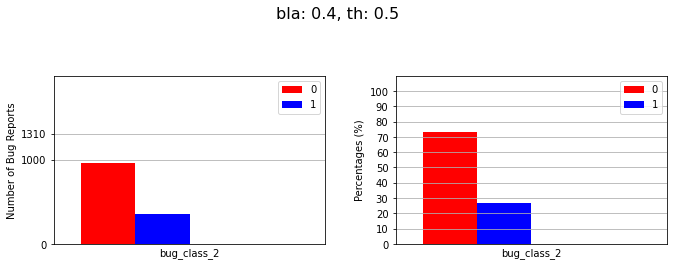

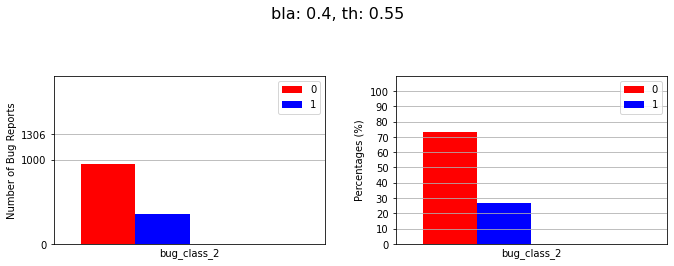

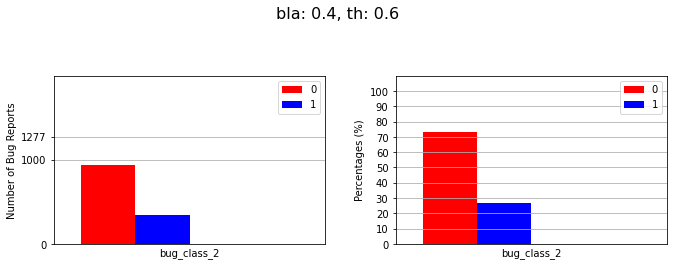

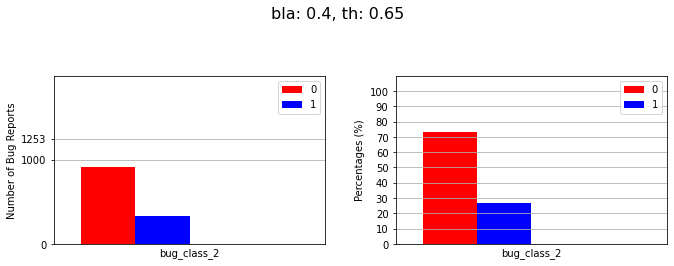

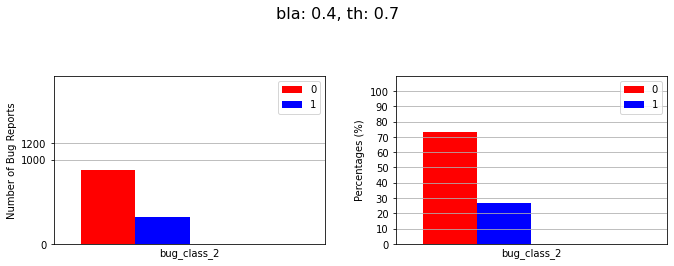

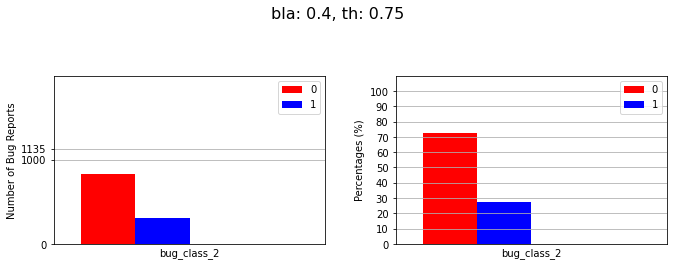

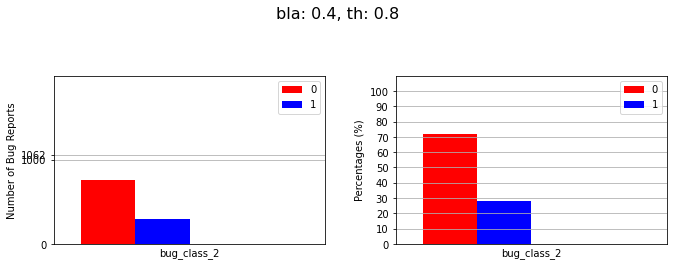

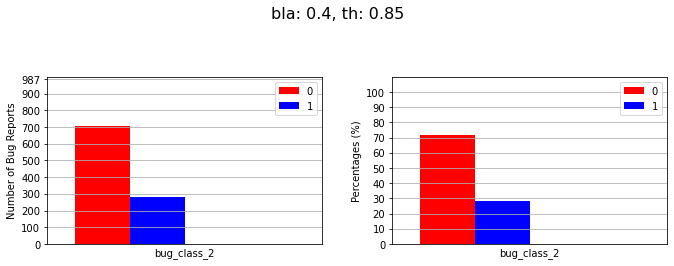

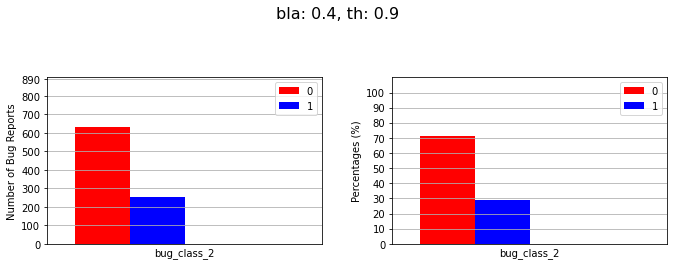

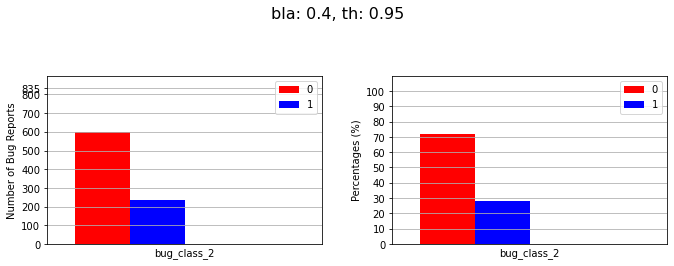

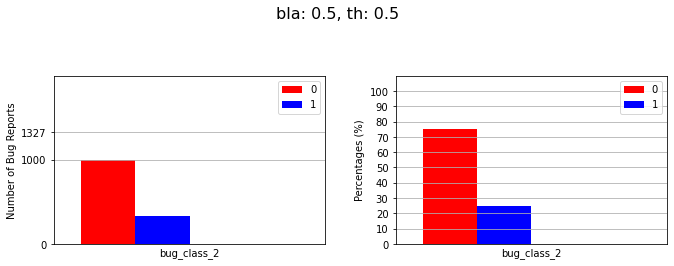

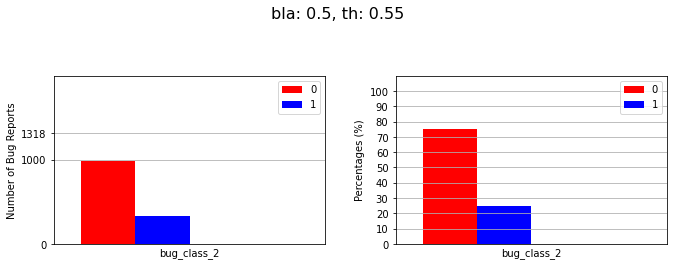

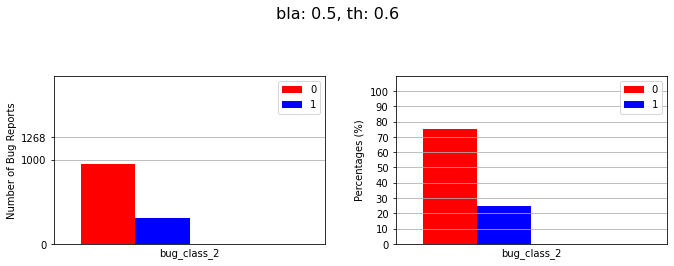

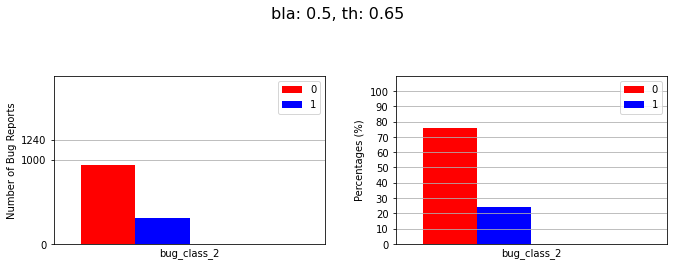

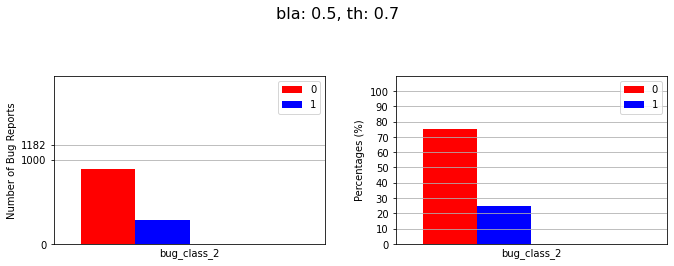

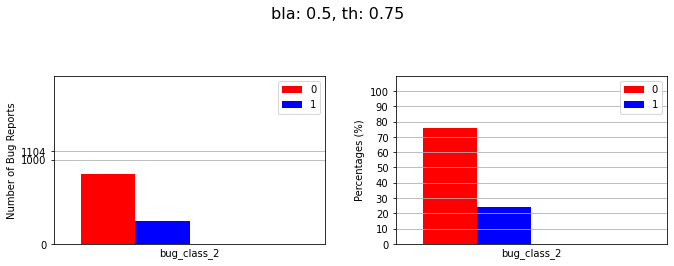

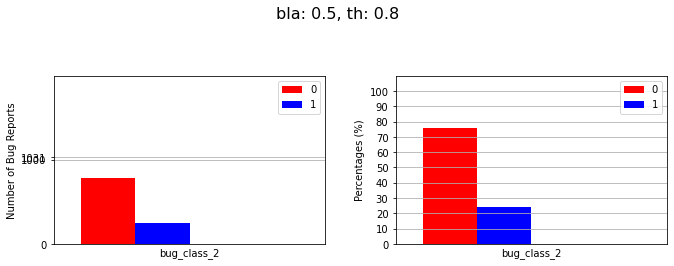

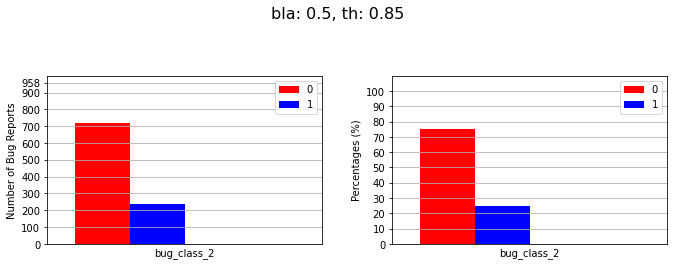

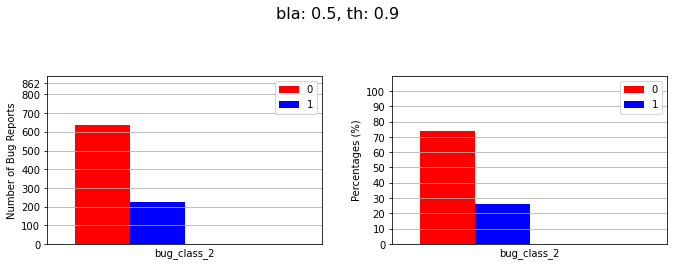

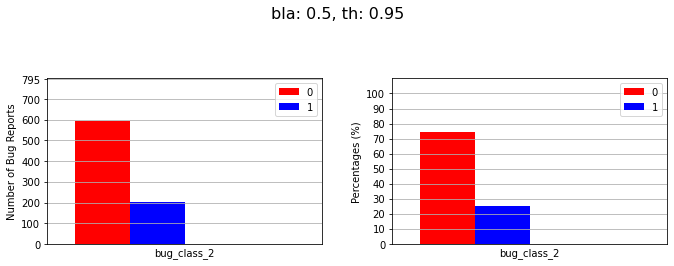

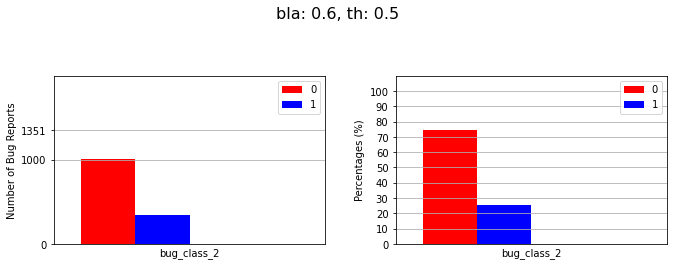

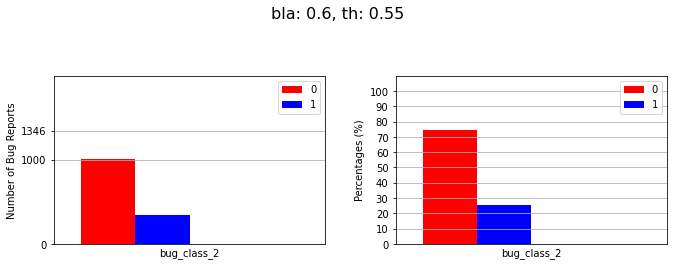

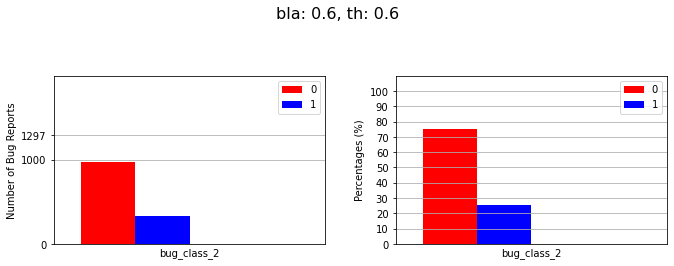

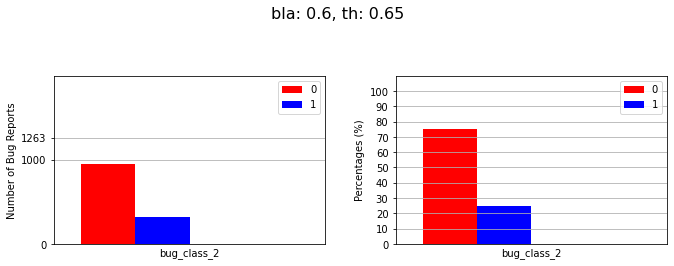

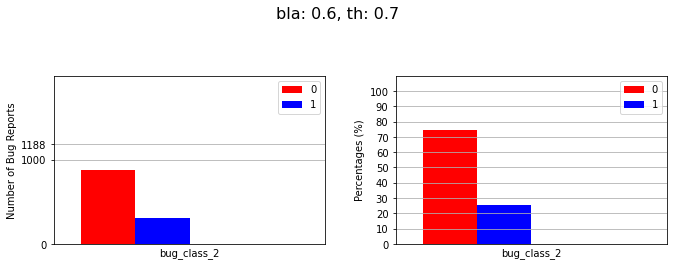

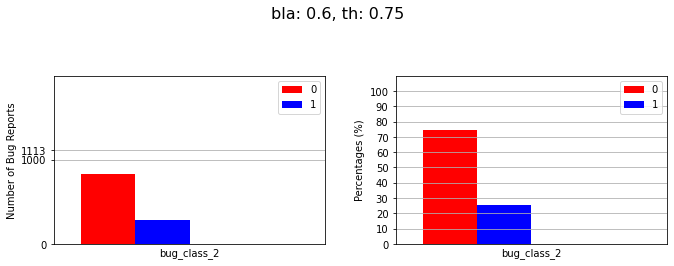

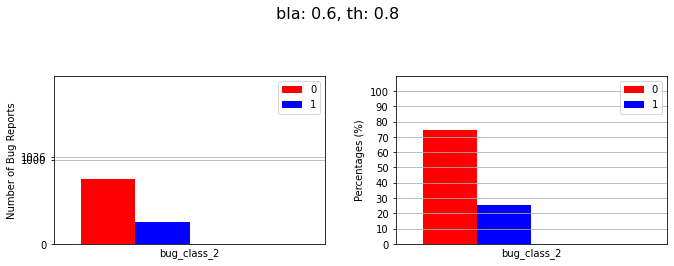

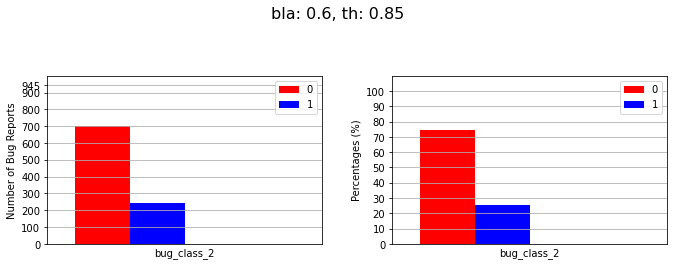

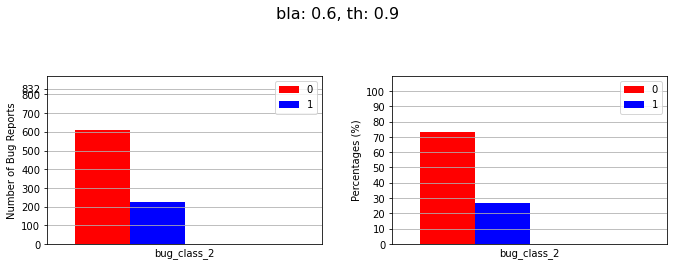

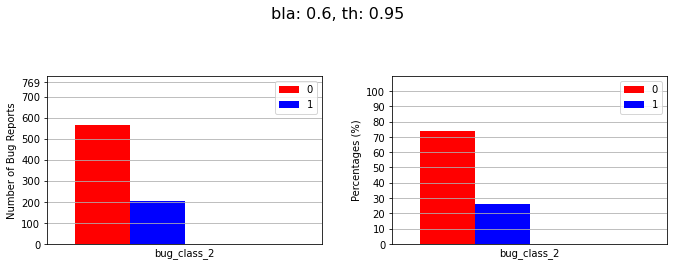

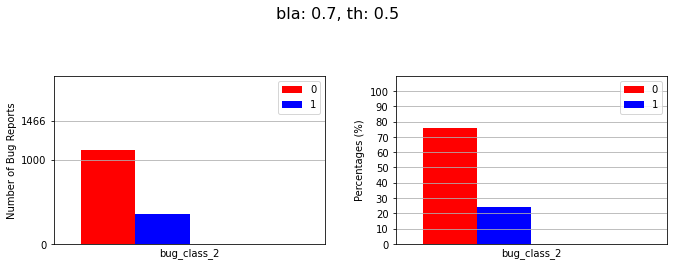

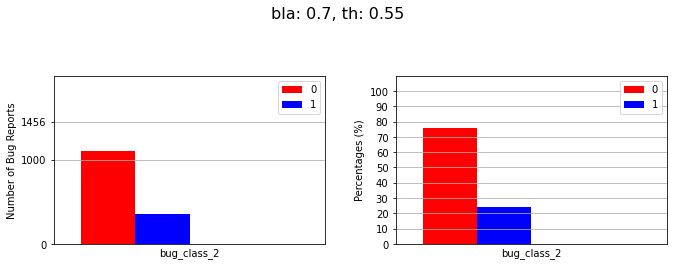

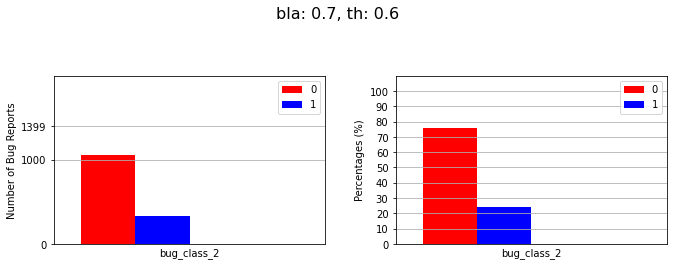

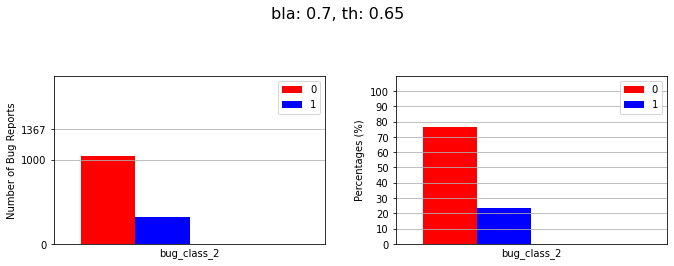

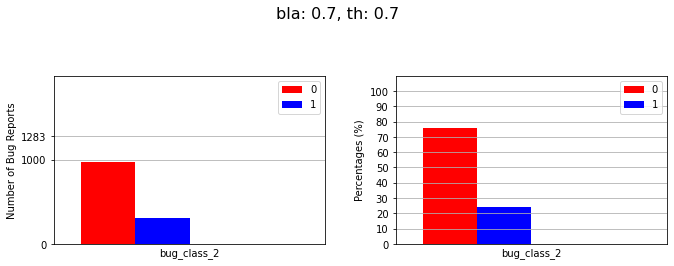

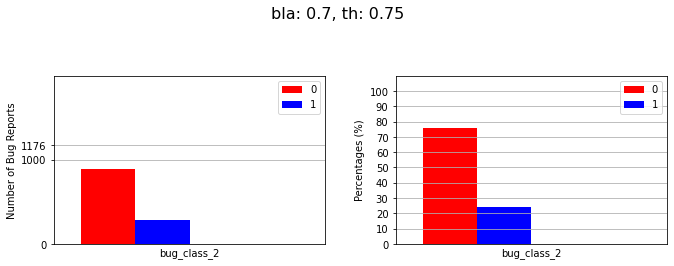

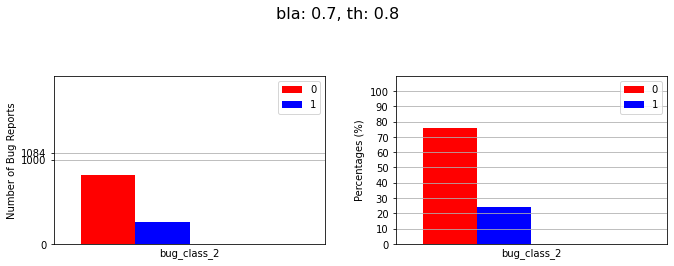

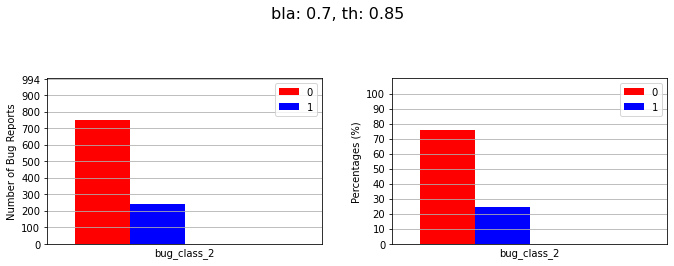

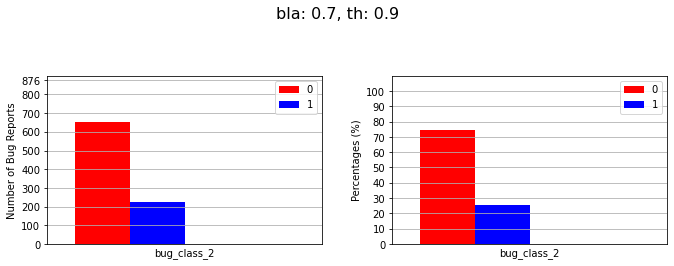

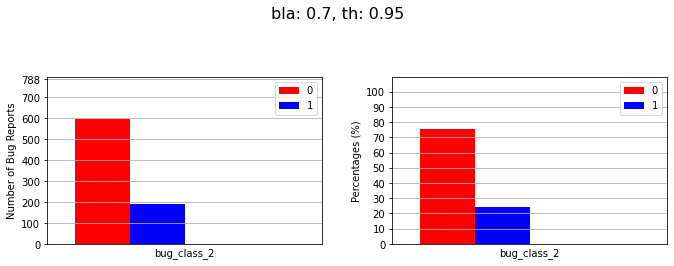

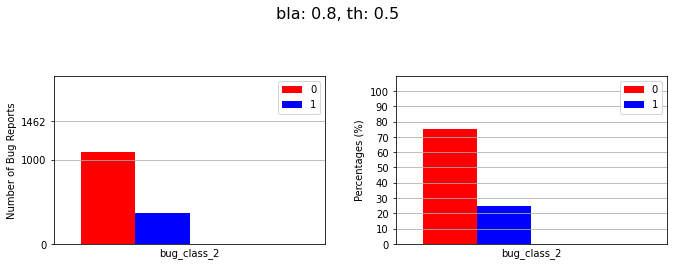

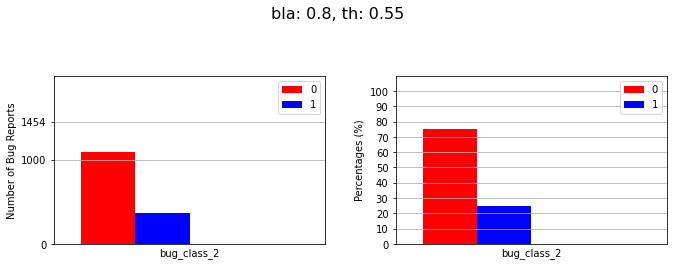

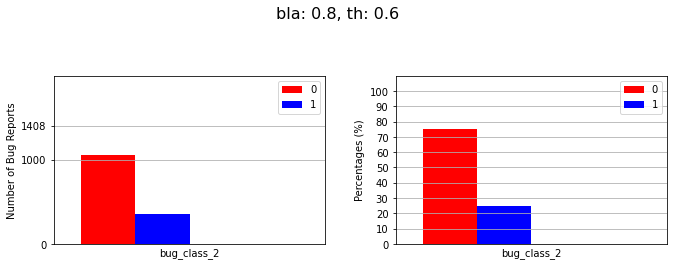

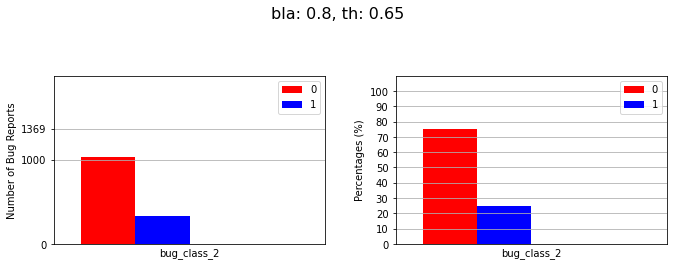

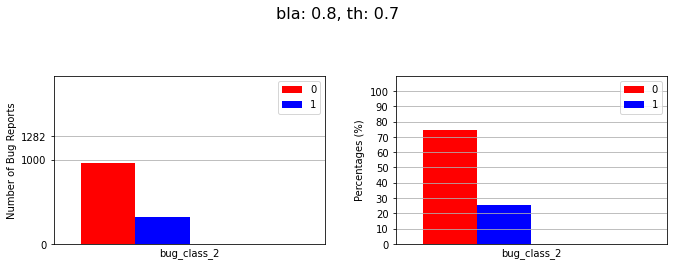

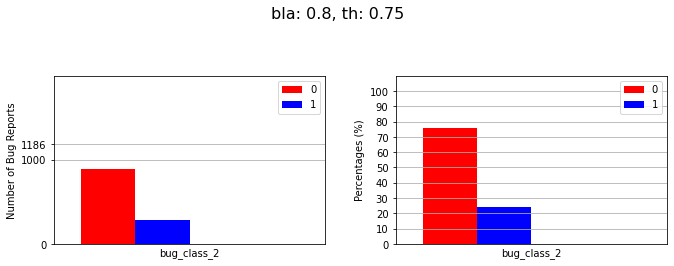

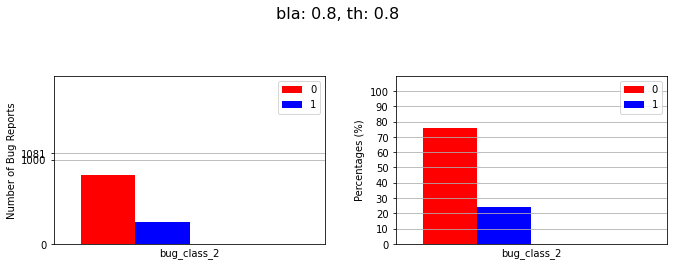

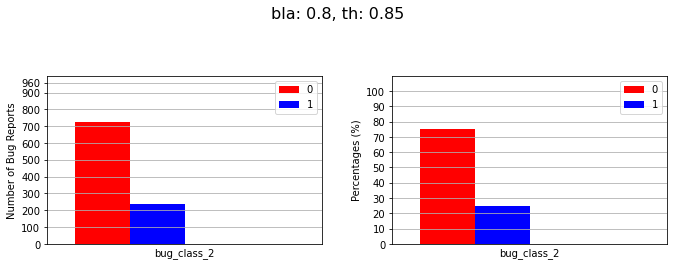

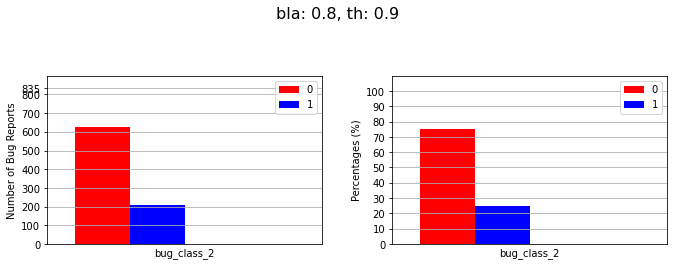

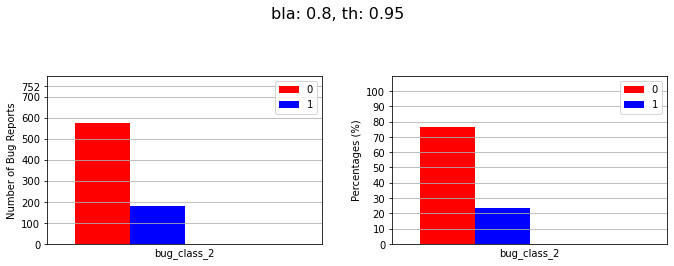

In [30]:
cddd.plotm(
    df_main_bug_preds, 
    bpfd_data.df_data_bug_preds)

In [31]:
cddd.df_data_bug_class_distribution

{0.4: {0.5: {'bug_class_num': {'bug_class_2': {'0': 960, '1': 350}},
   'bug_class_per': {'bug_class_2': {'0': 73.2824427480916,
     '1': 26.717557251908396}},
   'bug_class_ratio': {'bug_class_2': {'0/1': 2.742857142857143}}},
  0.55: {'bug_class_num': {'bug_class_2': {'0': 956, '1': 350}},
   'bug_class_per': {'bug_class_2': {'0': 73.20061255742726,
     '1': 26.79938744257274}},
   'bug_class_ratio': {'bug_class_2': {'0/1': 2.7314285714285713}}},
  0.6: {'bug_class_num': {'bug_class_2': {'0': 936, '1': 341}},
   'bug_class_per': {'bug_class_2': {'0': 73.29678935003915,
     '1': 26.703210649960845}},
   'bug_class_ratio': {'bug_class_2': {'0/1': 2.7448680351906156}}},
  0.65: {'bug_class_num': {'bug_class_2': {'0': 920, '1': 333}},
   'bug_class_per': {'bug_class_2': {'0': 73.42378292098962,
     '1': 26.576217079010373}},
   'bug_class_ratio': {'bug_class_2': {'0/1': 2.7627627627627627}}},
  0.7: {'bug_class_num': {'bug_class_2': {'0': 875, '1': 325}},
   'bug_class_per': {'bug_cl

# CalcAcc

In [32]:
class MyConfusionMatrix():
    def __init__(self, num_classes):
        # rows: actual, columns: prediction
        self.confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    
    
    def update(self, y, yhat_indices):
        for actual, pred in zip(y, yhat_indices):
            self.confusion_matrix[actual, pred] += 1
    
    
    def calc_accuracy(self):
        diagon = self.confusion_matrix.diagonal()
        # accuracy
        total_samples = self.confusion_matrix.sum()
        total_corrects = diagon.sum()
        accuracy = 100 * (total_corrects / total_samples)
        
        # accuracy per class
        # sum(1): 1 referes to sum for each row
        samples_per_class = self.confusion_matrix.sum(1)
        accuracy_per_class = 100 * (np.divide(diagon, samples_per_class))
        
        return accuracy, accuracy_per_class.tolist()
    
    
    def get_cf(self):
        return self.confusion_matrix.tolist()

In [33]:
class CalcAcc():
    
    def __init__(self, df_main_bug_preds, threshold, bug_localization_accuracy, num_bugc2_classes):
        self.confusion_matrix = {}
        self.mycf = {}
        
        self.df_main_bug_preds = df_main_bug_preds
        self.threshold = threshold
        self.bla = bug_localization_accuracy
        
        self.samples_num = {}
        self.num_true = {} # {"0.50": {"simple": 100, "bc_2": 200, "bc_3":200, "bc_4":200}, ...}
        self.accuracy = {} # {"0.50": {"simple": 92.0, "bc_2": 100, "bc_3":100, "bc_4":100}, ...}
        self.brIDs_num = {}
        
        for bla in bug_localization_accuracy:
            self.samples_num[bla] = {}
            self.num_true[bla] = {}
            self.accuracy[bla] = {}
            self.brIDs_num[bla] = {}
            #--
            self.confusion_matrix[bla] = {}
            self.mycf[bla] = {}
            
            for th in threshold:
                self.num_true[bla][th] = {
                    "simple": 0, 
                    "bc_2": 0,
                }
            
                # bc: bug class
                self.accuracy[bla][th] = {
                    "simple": None, 
                    "bc_2": None, 
                }
                
                self.mycf[bla][th] = {}
                self.confusion_matrix[bla][th] = MyConfusionMatrix(num_bugc2_classes)
    
    
    # ================== simple ==================
    
    def simple(self, df_data_pred_filtered):
        for i, bla in enumerate(self.bla):
            for j, th in enumerate(self.threshold):
                df_data_pred_filtered[bla][j].apply(lambda row: self.sub_simple_(row, bla, th), axis=1)
                self.samples_num[bla][th] = len(df_data_pred_filtered[bla][j])
                print(bla, th, self.samples_num[bla][th])
                self.accuracy[bla][th]["simple"] = (self.num_true[bla][th]["simple"] / self.samples_num[bla][th]) * 100
    
    
    def sub_simple_(self, row, bla, th):
        tem = row.tail(1).item()
        if row["label"] == tem:
            self.num_true[bla][th]["simple"] += 1
    
    
    # =============================================
    #                   bug class
    # =============================================
    
    def bug_class(self, df_data_bug_preds):
        for i, bla in enumerate(self.bla):
            for j, th in enumerate(self.threshold):
                self.brIDs_num[bla][th] = len(df_data_bug_preds[bla][j])
                df_data_bug_preds[bla][j].apply(lambda row: self.sub_bug_class_(row, bla, th), axis=1)
                
                
                my_accuracy, acc_per = self.confusion_matrix[bla][th].calc_accuracy()
                self.accuracy[bla][th]["bc_2"] = my_accuracy
                # ----
                
                self.mycf[bla][th]["confusion_matrix"] = self.confusion_matrix[bla][th].get_cf()
                self.mycf[bla][th]["acc_per_class"] = acc_per
    
    
    def sub_bug_class_(self, row, bla, th):
        temp = self.df_main_bug_preds[(self.df_main_bug_preds["bug_report_id"] == row["bug_report_id"])]
        
        if row["bug_class_2"] == temp["bug_class_2"].item():
            self.num_true[bla][th]["bc_2"] += 1
        
        # confusion_matrix.update(y, yhat_indices)
        self.confusion_matrix[bla][th].update([temp["bug_class_2"].item()], [row["bug_class_2"]])

## obj

In [34]:
ca = CalcAcc(df_main_bug_preds, knn_accuracy_threshold, bug_localization_accuracy, 2)
ca.simple(datp_data.df_data_pred_filtered)
ca.bug_class(bpfd_data.df_data_bug_preds)

0.4 0.5 6005
0.4 0.55 5966
0.4 0.6 5751
0.4 0.65 5597
0.4 0.7 5258
0.4 0.75 4819
0.4 0.8 4389
0.4 0.85 3972
0.4 0.9 3478
0.4 0.95 3231
0.5 0.5 6552
0.5 0.55 6476
0.5 0.6 6145
0.5 0.65 5958
0.5 0.7 5569
0.5 0.75 5096
0.5 0.8 4662
0.5 0.85 4157
0.5 0.9 3682
0.5 0.95 3375
0.6 0.5 6969
0.6 0.55 6914
0.6 0.6 6576
0.6 0.65 6333
0.6 0.7 5825
0.6 0.75 5329
0.6 0.8 4808
0.6 0.85 4293
0.6 0.9 3780
0.6 0.95 3490
0.7 0.5 7867
0.7 0.55 7760
0.7 0.6 7368
0.7 0.65 7168
0.7 0.7 6592
0.7 0.75 5892
0.7 0.8 5342
0.7 0.85 4776
0.7 0.9 4233
0.7 0.95 3835
0.8 0.5 8018
0.8 0.55 7955
0.8 0.6 7617
0.8 0.65 7374
0.8 0.7 6778
0.8 0.75 6165
0.8 0.8 5511
0.8 0.85 4823
0.8 0.9 4278
0.8 0.95 3941


In [35]:
ca.accuracy

{0.4: {0.5: {'simple': 69.17568692756036, 'bc_2': 73.2824427480916},
  0.55: {'simple': 69.10828025477707, 'bc_2': 73.20061255742726},
  0.6: {'simple': 69.43140323422014, 'bc_2': 73.06186374314801},
  0.65: {'simple': 69.69805252814008, 'bc_2': 73.10454908220272},
  0.7: {'simple': 70.50209205020921, 'bc_2': 72.66666666666667},
  0.75: {'simple': 71.52936293836896, 'bc_2': 72.33480176211454},
  0.8: {'simple': 73.00068352699932, 'bc_2': 71.939736346516},
  0.85: {'simple': 73.91742195367573, 'bc_2': 71.3272543059777},
  0.9: {'simple': 75.47441058079356, 'bc_2': 71.01123595505618},
  0.95: {'simple': 76.07551841535128, 'bc_2': 71.49700598802396}},
 0.5: {0.5: {'simple': 71.33699633699634, 'bc_2': 74.67972871137904},
  0.55: {'simple': 71.32489190858554, 'bc_2': 74.65857359635811},
  0.6: {'simple': 72.00976403580145, 'bc_2': 75.0},
  0.65: {'simple': 72.55790533736153, 'bc_2': 75.08064516129032},
  0.7: {'simple': 73.87322679116538, 'bc_2': 75.1269035532995},
  0.75: {'simple': 74.941

In [36]:
ca.mycf

{0.4: {0.5: {'confusion_matrix': [[928, 32], [318, 32]],
   'acc_per_class': [96.66666666666667, 9.142857142857142]},
  0.55: {'confusion_matrix': [[924, 32], [318, 32]],
   'acc_per_class': [96.65271966527197, 9.142857142857142]},
  0.6: {'confusion_matrix': [[903, 33], [311, 30]],
   'acc_per_class': [96.47435897435898, 8.797653958944283]},
  0.65: {'confusion_matrix': [[888, 32], [305, 28]],
   'acc_per_class': [96.52173913043478, 8.408408408408409]},
  0.7: {'confusion_matrix': [[846, 29], [299, 26]],
   'acc_per_class': [96.68571428571428, 8.0]},
  0.75: {'confusion_matrix': [[800, 26], [288, 21]],
   'acc_per_class': [96.85230024213075, 6.796116504854369]},
  0.8: {'confusion_matrix': [[747, 19], [279, 17]],
   'acc_per_class': [97.51958224543081, 5.743243243243244]},
  0.85: {'confusion_matrix': [[689, 17], [266, 15]],
   'acc_per_class': [97.59206798866855, 5.338078291814947]},
  0.9: {'confusion_matrix': [[621, 13], [245, 11]],
   'acc_per_class': [97.94952681388013, 4.296875]

In [37]:
bpfd_data.df_data_bug_preds

{0.4: [      bug_report_id  bug_class_2
  0             27757            0
  1             27760            0
  2             27761            0
  3             27762            0
  4             27764            0
  ...             ...          ...
  1305          39404            0
  1306          39420            0
  1307          39475            0
  1308          39492            1
  1309          39509            1
  
  [1310 rows x 2 columns],
        bug_report_id  bug_class_2
  0             27757            0
  1             27760            0
  2             27761            0
  3             27762            0
  4             27764            0
  ...             ...          ...
  1301          39404            0
  1302          39420            0
  1303          39475            0
  1304          39492            1
  1305          39509            1
  
  [1306 rows x 2 columns],
        bug_report_id  bug_class_2
  0             27757            0
  1             27760    

# Save results

In [38]:
def save_to_file_results(
    which_method,
    dataset_name, 
    preprocessing_params, 
    bug_localization_accuracy, 
    knn_model_params, 
    knn_accuracy_threshold, 

    samples_num, 
    brIDs_num, 

    samples_num_pred, 
    brIDs_num_pred, 

    df_data_bug_class_distribution,
    accuracies, 
    
    cf,
    
    result_path):
    
    tempStructure = {
        "which_method":                   which_method,
        "dataset":                        dataset_name, 
        "preprocessing_params":           preprocessing_params, 
        "bug_localization_accuracy":      bug_localization_accuracy, 
        "knn_model_params":               knn_model_params,
        "knn_accuracy_threshold":         knn_accuracy_threshold,
        
        "samples_num":                    samples_num,
        "brIDs_num":                      brIDs_num,
        
        "samples_num_pred":               samples_num_pred,
        "brIDs_num_pred":                 brIDs_num_pred,
        
        "df_data_bug_class_distribution": df_data_bug_class_distribution,
        "accuracies":                     accuracies, 
        
        "confusion_matrix":               cf,
        
    }

    with open(result_path, "w") as fout:
        json.dump(tempStructure, fout)

## call

In [39]:
save_to_file_results(
    which_method,
    dataset_file_name, 
    preprocessing_params, 
    bug_localization_accuracy, 
    knn_model_params, 
    knn_accuracy_threshold, 

    len(df_data_pred[0.8]), 
    brIDs_num, 
    
    ca.samples_num, 
    ca.brIDs_num, 

    cddd.df_data_bug_class_distribution,
    ca.accuracy, 
    
    ca.mycf,
    
    mypaths["output_performance"]
)